**Телеком — Поиск клиентов с неоптимальными тарифами**

Задача: 

Найти клиентов, которые:

- а) переплачивают на текущих тарифах; 

- б) сэкономят, если перейдут на более дорогой тариф




**Описание данных:**

Датасет:  `/datasets/telecom_dataset.csv`  

**Колонки:**

- **user_id** — идентификатор клиента  
- **date** — дата статистики  
- **direction** — направление вызовов:  
  - `out` — исходящий вызов  
  - `internal` — маркер внутренних и внешних вызовов  
- **operator_id** — идентификатор оператора  
- **is_missed_call** — маркер пропущенных вызовов  
- **calls_count** — количество звонков  
- **call_duration** — длительность звонка без учёта времени ожидания  
- **total_call_duration** — длительность звонка с учётом времени ожидания  

Датасет:`/datasets/telecom_clients.csv`  

**Колонки:**

- **user_id** — идентификатор клиента  
- **tariff_plan** — тарифный план клиента  
- **date_start** — дата регистрации клиента в сервисе  



**Входящие и внутренние звонки** — бесплатны на всех тарифах. 

| Тариф | Ежемесячная плата (₽) | Доп. плата за оператора (₽) | Исходящие внутри сети (мин) | Цена сверх лимита (₽/мин) | Исходящие кроме внутренних (₽/мин) |
|--------|----------------------|----------------------------|----------------------------|--------------------------|---------------------------------|
| A      | 4000                 | 50                         | 2000                       | 0.10                     | 0.3                             |
| B      | 2000                 | 150                        | 500                        | 0.15                     | 0.5                             |
| C      | 1000                 | 300                        | 0                          | 0.30                     | 0.7                             |


**План работы:**
1. Загрузка и изучение данных
 - Промежуточные выводы
2. Предобработка данных:
 - Обработка пропусков
 - Обработка дубликатов
 - Обработка аномалий
 - Приведение к правильным типам данных
 - Прочее (исходя из найденных проблем в датасете)
 - Промежуточные выводы
3. Исследовательский анализ данных:
 - Определение и поиск активных пользователей
 - Исследование затрат пользователей (активных)
 - Поиск пользователей, которые переплачивают за услуги связи
4. Проверка статистических гипотез
5. Общие выводы и рекомендации

# Загрузка и изучение данных

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import shapiro, wilcoxon

pd.set_option('display.float_format', '{:,.3f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_calls = pd.read_csv('/datasets/telecom_dataset.csv')
df_clients = pd.read_csv('/datasets/telecom_clients.csv')

In [3]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


В столбцах internal и operator_id есть пропуски. Также наблюдается несоответствие типов данных в столбцах date и internal, а также в operator_id.

In [4]:
df_calls['date'] = pd.to_datetime(df_calls['date']).dt.tz_localize(None)

df_calls['operator_id'] = df_calls['operator_id'].astype('Int64')

In [5]:
duplicate_count_calls = df_calls.duplicated().sum()

duplicate_count_calls

4900

В данных о звонках найдено 4900 дублирующихся записей.

In [6]:
# Удаление дубликатов из данных о звонках
df_calls = df_calls.drop_duplicates()

duplicate_count_cleaned = df_calls.duplicated().sum()

print(f"После удаления дубликатов осталось {duplicate_count_cleaned} дублирующихся записей.")

После удаления дубликатов осталось 0 дублирующихся записей.


Посмотрим на пропуски в столбце operator_id

In [7]:
missing_operator_analysis = df_calls[df_calls['operator_id'].isna()]['is_missed_call'].value_counts()

missing_operator_analysis

True     7343
False     113
Name: is_missed_call, dtype: int64

Большинство пропусков относится к пропущенным вызовам (is_missed_call = True).
При пропущенном вызове, видимо, оператор не фиксируется, поскольку разговор не состоялся. Пока что оставим эти пропуски как есть.

In [8]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


Пропуски отсутствуют. Столбец date_start приведем к формату даты/времени

In [9]:
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

In [10]:
duplicates_check = df_clients.duplicated().unique()
duplicates_check

array([False])

Дубликатов нет.

In [11]:
# Подсчет количества уникальных клиентов
unique_clients = df_calls['user_id'].nunique()

# Подсчет количества уникальных операторов
unique_operators = df_calls['operator_id'].nunique()

unique_clients, unique_operators

(307, 1092)

Количество уникальных клиентов: 307

Количество уникальных операторов: 1092

Посмотрим на уникальные значения в датафрейме df_clients:

In [12]:
total_unique_clients = df_clients['user_id'].nunique()

total_unique_tariffs = df_clients['tariff_plan'].nunique()

tariff_distribution = df_clients['tariff_plan'].value_counts()

print(f"Общее количество уникальных клиентов: {total_unique_clients}")
print(f"Количество доступных тарифов: {total_unique_tariffs}")
print("Распределение клиентов по тарифам:")
print(tariff_distribution)


Общее количество уникальных клиентов: 732
Количество доступных тарифов: 3
Распределение клиентов по тарифам:
C    395
B    261
A     76
Name: tariff_plan, dtype: int64


Количество уникальных клиентов в двух датасетах сильно разнится, проверим сколько клиентов совпадает между датасетами:

In [13]:
common_clients = df_clients['user_id'].isin(df_calls['user_id']).sum()  # Количество клиентов из df_clients, которые есть в df_calls

common_clients

307

Получается, что в df_clients есть 425 лишних клиента, которые отсутствуют в данных о звонках.
Возможно, это клиенты, которые зарегистрировались, но не совершали звонков.

Проверим, что каждому клиенту присвоен только один тариф:

In [14]:
clients_with_multiple_tariffs = df_clients.groupby('user_id')['tariff_plan'].nunique()
multiple_tariff_clients = clients_with_multiple_tariffs[clients_with_multiple_tariffs > 1]

multiple_tariff_clients

Series([], Name: tariff_plan, dtype: int64)

Определим минимальную и максимальную даты в данных о звонках


In [15]:
min_date = df_calls['date'].min()
max_date = df_calls['date'].max()

min_date, max_date

(Timestamp('2019-08-02 00:00:00'), Timestamp('2019-11-28 00:00:00'))

Данные о звонках охватывают период с 2 августа 2019 по 28 ноября 2019.

Проверим, есть ли аномалии по длительности вызовов в сутки:

In [16]:
# Перевод времени звонков из секунд в часы
df_calls['total_call_duration_hours'] = df_calls['total_call_duration'] / 60  

operators_over_24h = df_calls.groupby(['operator_id', 'date'])['total_call_duration_hours'].sum()

operators_over_limit = operators_over_24h[operators_over_24h > 24]

operators_over_limit

operator_id  date      
879896       2019-08-05   35.950
             2019-08-06   95.950
             2019-08-07   53.000
             2019-08-08   25.983
             2019-08-09   48.600
                           ...  
972410       2019-11-27   31.750
             2019-11-28   56.167
972412       2019-11-27   35.617
             2019-11-28   40.183
972460       2019-11-28   25.783
Name: total_call_duration_hours, Length: 7929, dtype: float64


Имеются операторы, наговорившие больше 24 часов за сутки, что невозможно.

In [17]:
total_operators = df_calls['operator_id'].nunique()

operators_exceeding_limit = operators_over_limit.index.get_level_values('operator_id').nunique()

percentage_exceeding = (operators_exceeding_limit / total_operators) * 100

operators_exceeding_list = operators_over_limit.index.get_level_values('operator_id').unique()

summary_df = pd.DataFrame({
    "Всего операторов": [total_operators],
    "Операторов с превышением лимита": [operators_exceeding_limit],
    "Процент превышения (%)": [percentage_exceeding]
})

display(summary_df)

,Всего операторов,Операторов с превышением лимита,Процент превышения (%)
0,1092,570,52.198



Более 50% операторов работают больше 24 часов в сутки - явная аномалия в данных.

In [18]:
# Операторы с перегрузкой (более 24 часов в сутки)
df_calls['total_call_duration_hours'] = df_calls['total_call_duration'] / 60  

operators_over_24h = df_calls.groupby(['operator_id', 'date'])['total_call_duration_hours'].sum()

operators_over_limit = operators_over_24h[operators_over_24h > 24]

operators_over_24h_list = operators_over_limit.index.get_level_values('operator_id').unique()

clients_with_overloaded_operators = df_calls[df_calls["operator_id"].isin(operators_over_24h_list)]["user_id"].nunique()

print(f"Количество уникальных клиентов, использующих операторов с перегрузкой более 24 часов: {clients_with_overloaded_operators}")


Количество уникальных клиентов, использующих операторов с перегрузкой более 24 часов: 169



Значит, проблема не связана с отдельными клиентами, а широко распространена.

In [19]:
# Фильтруем звонки аномальных операторов (более 24 часов в сутки)
calls_from_overloaded_operators = df_calls[df_calls["operator_id"].isin(operators_over_24h_list)]

call_direction_distribution = calls_from_overloaded_operators["direction"].value_counts()

print("Распределение направлений звонков среди аномальных операторов:")
display(call_direction_distribution)


Распределение направлений звонков среди аномальных операторов:


out    25972
in      9957
Name: direction, dtype: int64

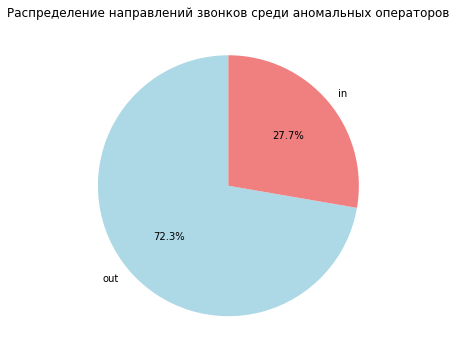

In [20]:
plt.figure(figsize=(6, 6))
call_direction_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title("Распределение направлений звонков среди аномальных операторов")
plt.ylabel('')
plt.show()


in     10046
out     3027
Name: direction, dtype: int64

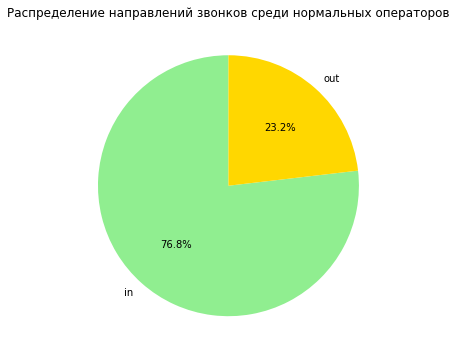

In [21]:
normal_operators = df_calls[~df_calls["operator_id"].isin(operators_over_24h_list)]

call_direction_distribution_normal = normal_operators["direction"].value_counts()

display(call_direction_distribution_normal)

plt.figure(figsize=(6, 6))
call_direction_distribution_normal.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'gold'])
plt.title("Распределение направлений звонков среди нормальных операторов")
plt.ylabel('')  # Убираем подпись оси Y
plt.show()



    
 - У аномальных операторов преобладают исходящие вызовы.
    
 - У "нормальных" операторов преобладают входящие вызовы.
 
Аномальные операторы могут быть автоматизированными системами или колл-центрами, так как совершают неестественно много исходящих звонков.

In [22]:
# Средняя продолжительность звонков у аномальных операторов
mean_duration_anomalous = calls_from_overloaded_operators["total_call_duration"].mean()

# Средняя продолжительность звонков у нормальных операторов
mean_duration_normal = normal_operators["total_call_duration"].mean()

print(f"Средняя продолжительность звонка у аномальных операторов: {mean_duration_anomalous:.2f} минут")
print(f"Средняя продолжительность звонка у нормальных операторов: {mean_duration_normal:.2f} минут")


Средняя продолжительность звонка у аномальных операторов: 1503.00 минут
Средняя продолжительность звонка у нормальных операторов: 204.42 минут



    
- Средняя длина вызова аномальных операторов ~ 25 часов, что нереалистично.
    
- Сердняя длина вызова "нормальных" операторов ~3.5 часа, что тоже кажется завышенным.

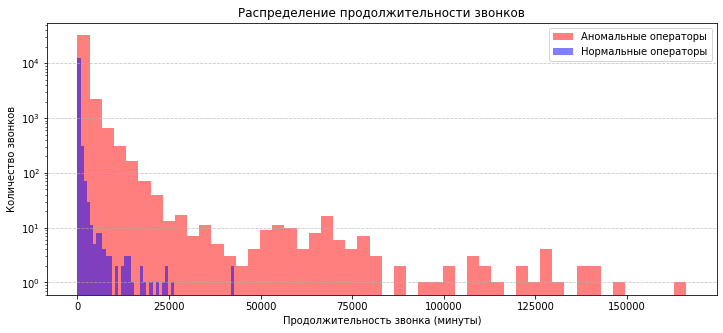

In [23]:
plt.figure(figsize=(12, 5))

plt.hist(calls_from_overloaded_operators["total_call_duration"], bins=50, alpha=0.5, label="Аномальные операторы", color="red")

plt.hist(normal_operators["total_call_duration"], bins=50, alpha=0.5, label="Нормальные операторы", color="blue")

plt.xlabel("Продолжительность звонка (минуты)")
plt.ylabel("Количество звонков")
plt.title("Распределение продолжительности звонков")
plt.legend()
plt.yscale("log")  # Логарифмическая шкала для лучшей видимости
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



 - Звонки у аномальных операторов (красная гистограмма) сильно смещены в область очень больших значений.
 - У нормальных операторов (синяя гистограмма) звонки распределены более равномерно, но всё равно есть длинные вызовы.
    
   **Вывод**:
    В учете длительности звонков наблюдаются явные ошибки. Можно либо обратиться к заказчику, чтобы уточнить как именно происходит запись данных, и можно ли интерпретировать результаты иначе.
    В нашем случае я не вижу альтернативы фильтровке данных (отбросить 52% аномальных значений).

In [24]:
df_calls_filtered = df_calls[~df_calls["operator_id"].isin(operators_over_24h_list)]

remaining_operators = df_calls_filtered["operator_id"].nunique()
remaining_calls = df_calls_filtered.shape[0]

print(f"После фильтрации осталось {remaining_operators} уникальных оператора.")
print(f"Количество записей о звонках после фильтрации: {remaining_calls}.")


После фильтрации осталось 522 уникальных оператора.
Количество записей о звонках после фильтрации: 13073.



**Выводы по предобработке данных:**

- Привели **даты** и **ID операторов** к нужному формату.  
- Удалили **4900** дубликатов, нашли **7456** пропусков в `operator_id`, большинство связано с пропущенными вызовами.  
- Выяснили, что в базе клиентов **732 записи**, но только **307** реально совершали звонки.  
- Проверили тарифы – у каждого клиента **только один тариф**.  
- **Нашли аномалию**: Более 50% операторов работают **больше 24 часов в сутки**. 

Для данного исследования важно отметить, что аномальными значениями будут считаться лишь значения, превышающие **24 часа в сутки**, посколько оператор в данном случае - не один человек, а один "канал связи", т.е. "одним оператором" могут быть несколько человек, работающие посменно. Поэтому, аптайм звонков до 24 часов можно считать нормой - например, для служб поддержки, работающих 24\7, или же клиентов, работающих со многими часовыми зонами. 


# Исследовательский анализ данных

**Поглядим на поведение оставшихся клиентов:**

<Figure size 720x360 with 0 Axes>

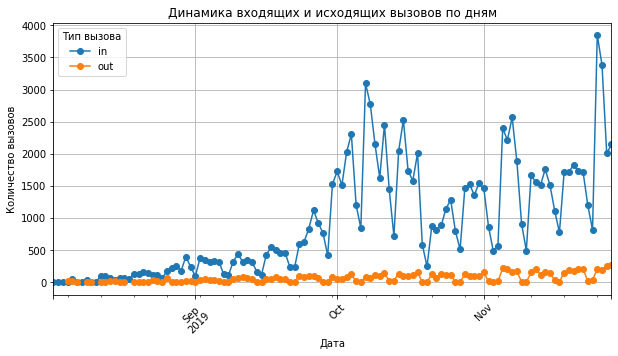

<Figure size 720x360 with 0 Axes>

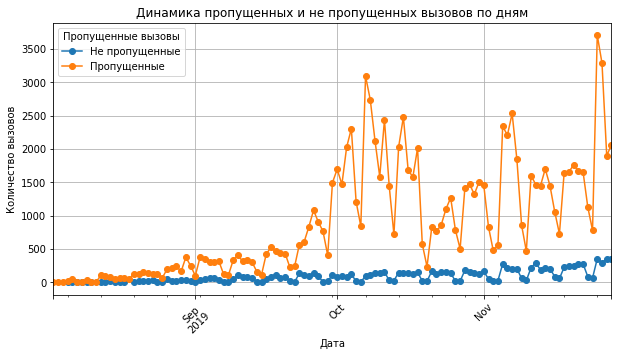

In [31]:
daily_call_counts = df_calls_filtered.groupby(['date', 'direction'])['calls_count'].sum().unstack()

# График динамики входящих и исходящих вызовов по дням
plt.figure(figsize=(10, 5))
daily_call_counts.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Динамика входящих и исходящих вызовов по дням")
plt.xlabel("Дата")
plt.ylabel("Количество вызовов")
plt.legend(title="Тип вызова")
plt.xticks(rotation=45)
plt.grid()
plt.show()

daily_missed_calls = df_calls_filtered.groupby(['date', 'is_missed_call'])['calls_count'].sum().unstack()

# График динамики пропущенных и не пропущенных вызовов по дням
plt.figure(figsize=(10, 5))
daily_missed_calls.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Динамика пропущенных и не пропущенных вызовов по дням")
plt.xlabel("Дата")
plt.ylabel("Количество вызовов")
plt.legend(title="Пропущенные вызовы", labels=["Не пропущенные", "Пропущенные"])
plt.xticks(rotation=45)
plt.grid()
plt.show()


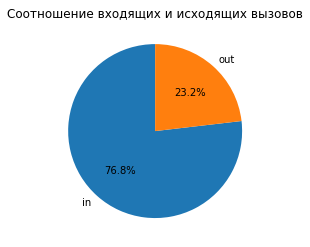

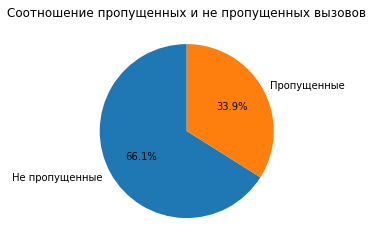

In [32]:
call_direction_counts = df_calls_filtered['direction'].value_counts()

# График соотношения входящих и исходящих вызовов
plt.figure(figsize=(6, 4))
plt.pie(call_direction_counts, labels=call_direction_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Соотношение входящих и исходящих вызовов")
plt.show()

missed_calls_counts = df_calls_filtered['is_missed_call'].value_counts()

# График пропущенных и не пропущенных вызовов
plt.figure(figsize=(6, 4))
plt.pie(missed_calls_counts, labels=["Не пропущенные", "Пропущенные"], autopct='%1.1f%%', startangle=90)
plt.title("Соотношение пропущенных и не пропущенных вызовов")
plt.show()


 - Входящих вызовов больше, чем исходящих.
 - Есть резкие скачки в количестве вызовов – возможно, это выходные, праздники или технические сбои.
 - Пропущенные вызовы растут в пиковые дни, что может указывать на перегрузку операторов.

Посмотрим на распределение звонков по дням недели:

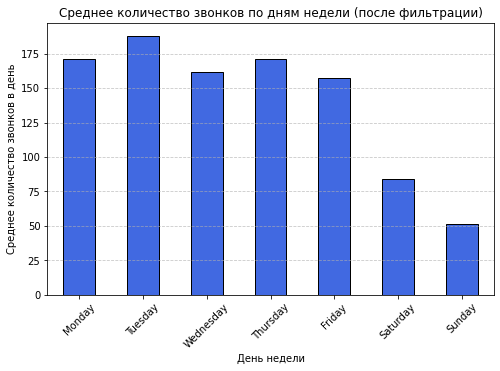

In [33]:
df_calls_filtered['weekday'] = df_calls_filtered['date'].dt.day_name()

calls_by_weekday_avg = df_calls_filtered.groupby('weekday')['calls_count'].sum() / df_calls_filtered['date'].nunique()

calls_by_weekday_avg = calls_by_weekday_avg.reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(8, 5))
calls_by_weekday_avg.plot(kind='bar', color='royalblue', edgecolor='black')
plt.title("Среднее количество звонков по дням недели (после фильтрации)")
plt.xlabel("День недели")
plt.ylabel("Среднее количество звонков в день")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Отчётливо виден спад количества звонков в выходные дни.

Посмотрим на распределение данных во времени в зависимости от тарифа:

In [34]:
df_calls_filtered = df_calls_filtered.merge(df_clients[['user_id', 'tariff_plan']], on="user_id", how="left")
df_calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,total_call_duration_hours
0,166377,2019-08-04,in,False,<NA>,True,2,0,4,0.067
1,166377,2019-08-05,out,True,880022,True,3,0,5,0.083
2,166377,2019-08-05,out,True,880020,True,1,0,1,0.017
3,166377,2019-08-05,out,True,880020,False,1,10,18,0.300
4,166377,2019-08-05,out,False,880022,True,3,0,25,0.417


<Figure size 720x360 with 0 Axes>

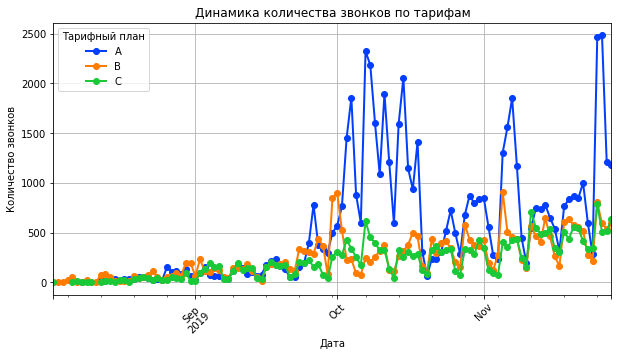

In [35]:

calls_by_tariff_over_time = df_calls_filtered.groupby(['date', 'tariff_plan'])['calls_count'].sum().unstack()

colors = sns.color_palette("bright", n_colors=len(calls_by_tariff_over_time.columns))

plt.figure(figsize=(10, 5))
calls_by_tariff_over_time.plot(kind='line', marker='o', figsize=(10, 5), color=colors, linewidth=2)
plt.title("Динамика количества звонков по тарифам")
plt.xlabel("Дата")
plt.ylabel("Количество звонков")
plt.legend(title="Тарифный план")
plt.xticks(rotation=45)
plt.grid()
plt.show()


- **Тариф A (синий)** – больше всего звонков, особенно с октября.  
- **Тариф C (зеленый)** – число звонков скачет, нестабильное использование.  
- **Тариф B (оранжевый)** – самый ровный, без резких изменений.  

- Наблюдаем общий рост звонков с сентября по ноябрь.  
- Тариф A – самый активный, тарифы В и С показывают более-менее одинаковую активность.


    
За критерий активности пользователей возьмем наличие звонков в последний месяц, т.к.: 
    
    - На графиках видно довольно мощный и стабильный рост активности клиентов в первые два месяца, однако использование устаревших данных (а в данном случае наш клиент был явно в ранней стадии запуска продукта) может исказить текущие тренды.
    
    - Актуальность данных – последний месяц предоставляет наиболее свежую информацию о поведении пользователей.
    
    - Пользователи могли изменять свои тарифы или привычки в течение нескольких месяцев. Последний месяц лучше отражает актуальную картину.


Уточним, какой процент данных будет отфильтрован при таком подходе.

In [36]:
last_month_start = df_calls_filtered['date'].max() - pd.DateOffset(months=1)

active_users_last_month = df_calls_filtered[df_calls_filtered['date'] >= last_month_start]['user_id'].unique()

total_users_before = df_calls_filtered['user_id'].nunique()

total_users_after = len(active_users_last_month)

filtered_percentage = ((total_users_before - total_users_after) / total_users_before) * 100

total_users_before, total_users_after, filtered_percentage


(307, 270, 12.052117263843648)



Процент пользователей, которые будут отфильтрованы: ~12.05%. Увеличим период и исключим из фильтрации тех, кто присоединился в октябре и ноябре.

In [37]:
adjusted_last_month_start_6w = df_calls_filtered['date'].max() - pd.DateOffset(weeks=6)

recent_users_oct_nov = df_clients[df_clients['date_start'].dt.month.isin([10, 11])]['user_id'].unique()

active_users_last_6w = df_calls_filtered[df_calls_filtered['date'] >= adjusted_last_month_start_6w]['user_id'].unique()

filtered_users_6w_oct_nov = set(df_calls_filtered['user_id'].unique()) - set(active_users_last_6w)
filtered_users_final_6w_oct_nov = filtered_users_6w_oct_nov - set(recent_users_oct_nov)

total_users_after_6w_oct_nov = total_users_before - len(filtered_users_final_6w_oct_nov)

filtered_percentage_6w_oct_nov = ((total_users_before - total_users_after_6w_oct_nov) / total_users_before) * 100

total_users_before, total_users_after_6w_oct_nov, filtered_percentage_6w_oct_nov


(307, 282, 8.143322475570033)


Процент отфильтрованных пользователей: ~8.14%, что уже несколько лучше.

Посмотрим на длительность звонков в зависимости от тарифа:

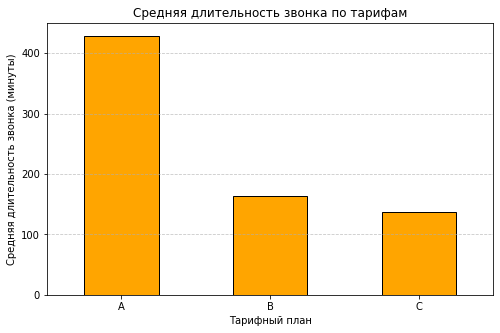

In [38]:
duration_by_tariff = df_calls_filtered.groupby('tariff_plan')['total_call_duration'].sum()
avg_duration_by_tariff = df_calls_filtered.groupby('tariff_plan')['total_call_duration'].mean()
df_duration = pd.DataFrame({'Общая длительность (минуты)': duration_by_tariff, 'Средняя длительность (минуты)': avg_duration_by_tariff})


plt.figure(figsize=(8, 5))
avg_duration_by_tariff.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Средняя длительность звонка по тарифам")
plt.xlabel("Тарифный план")
plt.ylabel("Средняя длительность звонка (минуты)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



- **Тариф A** – средний звонок длится дольше всех.

- **Тарифы B и C** – звонки короче.

На всех тарифах наблюдаются **аномально долгие** звонки. 

Потроим гистограмму распределения продолжительности звонков по операторам


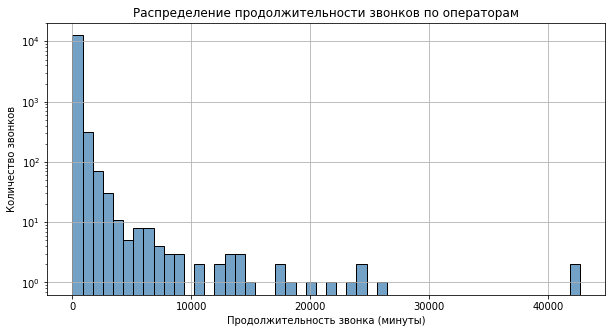

In [39]:
plt.figure(figsize=(10, 5))
sns.histplot(df_calls_filtered['total_call_duration'], bins=50, color='steelblue', edgecolor='black', log_scale=(False, True))

plt.title("Распределение продолжительности звонков по операторам")
plt.xlabel("Продолжительность звонка (минуты)")
plt.ylabel("Количество звонков")
plt.grid()
plt.show()


Построим гистограмму распределения длительности звонков без учета ожидания


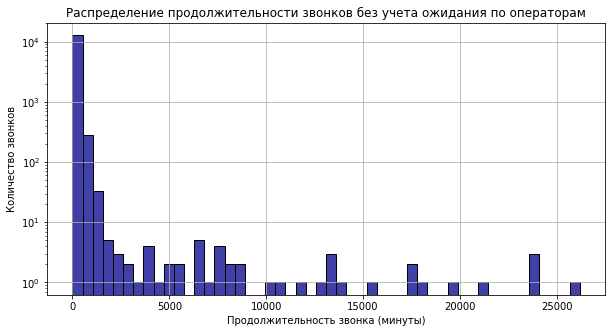

In [40]:
plt.figure(figsize=(10, 5))
sns.histplot(df_calls_filtered['call_duration'], bins=50, color='darkblue', edgecolor='black', log_scale=(False, True))

plt.title("Распределение продолжительности звонков без учета ожидания по операторам")
plt.xlabel("Продолжительность звонка (минуты)")
plt.ylabel("Количество звонков")
plt.grid()
plt.show()




- Видны вызовы, с нереалистично большой длительностью.   
- **Без учета ожидания звонки короче**, но всё равно есть выбросы с длительными вызовами.

Как было отмечено ранее, подобные аномалии могут быть случаями круглосуточной работы компании и неверным разделением (а точнее отсутствием разделения звонков).

Соотношение звонков внутри вне сети по тарифам:

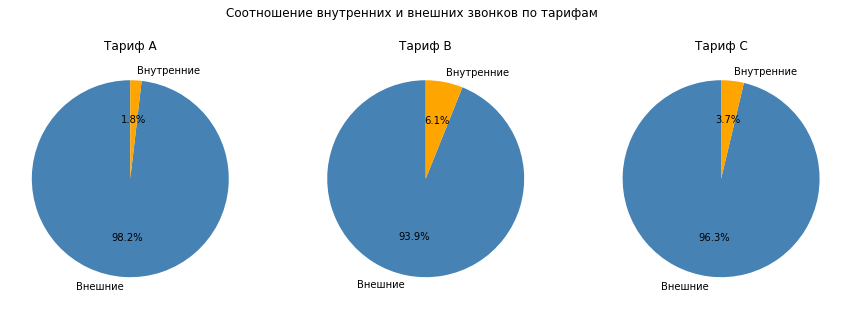

In [42]:
internal_external_calls = df_calls_filtered.groupby(['tariff_plan', 'internal'])['calls_count'].sum().unstack()

internal_external_calls.columns = ['Внешние', 'Внутренние']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

tariffs = internal_external_calls.index
colors = ['steelblue', 'orange']

for i, tariff in enumerate(tariffs):
    axes[i].pie(
        internal_external_calls.loc[tariff],
        labels=['Внешние', 'Внутренние'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    axes[i].set_title(f"Тариф {tariff}")

plt.suptitle("Соотношение внутренних и внешних звонков по тарифам")
plt.show()


 - Внутренние звонки составляют менее 3% во всех тарифах.
 
 - На тарифе A доля внутренних вызовов самая низкая – всего 1.9%.
 - В тарифах B и C – чуть больше, но всё равно незначительно (2.8% и 2.2%).
 - Внешние звонки преобладают во всех тарифах.

# Поиск клиентов с неоптимальными тарифами

Найдем активных пользователей с неоптимальными тарифами. с критерием активности за последние 6 недель и учётом пользователей, присоединившихся не раньше октября:

In [43]:
filtered_df_calls = df_calls_filtered[df_calls_filtered['user_id'].isin(active_users_last_6w) | 
                                      df_calls_filtered['user_id'].isin(recent_users_oct_nov)]

remaining_users_after_filter = filtered_df_calls['user_id'].nunique()
remaining_calls_after_filter = filtered_df_calls.shape[0]

remaining_users_after_filter, remaining_calls_after_filter


(282, 12721)

In [44]:
filtered_df_calls['month'] = filtered_df_calls['date'].dt.to_period('M')

last_month = filtered_df_calls['date'].max().month
last_year = filtered_df_calls['date'].max().year

active_users = filtered_df_calls[
    (filtered_df_calls['date'].dt.month == last_month) & (filtered_df_calls['date'].dt.year == last_year)
]['user_id'].unique()

df_active_calls = filtered_df_calls[
    (filtered_df_calls['user_id'].isin(active_users)) & 
    (filtered_df_calls['month'] == f"{last_year}-{last_month}")
]

# Группировка данных по пользователям и тарифам
user_call_stats = df_active_calls.groupby(['user_id', 'tariff_plan']).agg(
    total_call_duration=('total_call_duration', 'sum'),
    total_calls=('calls_count', 'sum'),
    unique_operators=('operator_id', 'nunique'),
    external_call_duration=('total_call_duration', lambda x: x[df_active_calls['internal'] == False].sum())
).reset_index()

# Детали тарифов
tariff_details = {
    "A": {"monthly_fee": 4000, "included_minutes": 2000, "extra_minute_cost": 0.1, "operator_fee": 50, "external_call_cost": 0.3},
    "B": {"monthly_fee": 2000, "included_minutes": 500, "extra_minute_cost": 0.15, "operator_fee": 150, "external_call_cost": 0.5},
    "C": {"monthly_fee": 1000, "included_minutes": 0, "extra_minute_cost": 0.3, "operator_fee": 300, "external_call_cost": 0.7}
}

# Функция расчета затрат с учетом всех параметров тарифа
def calculate_cost(row):
    tariff = tariff_details[row['tariff_plan']]
    base_cost = tariff["monthly_fee"]
    extra_minutes_cost = max(0, row['total_call_duration'] - tariff["included_minutes"]) * tariff["extra_minute_cost"]
    operator_fee = row['unique_operators'] * tariff["operator_fee"]
    external_calls_cost = row['external_call_duration'] * tariff["external_call_cost"]
    
    return base_cost + extra_minutes_cost + operator_fee + external_calls_cost

user_call_stats['calculated_cost'] = user_call_stats.apply(calculate_cost, axis=1)

# Определение неоптимальных тарифов
def find_better_tariff(row):
    current_cost = row['calculated_cost']
    best_tariff = row['tariff_plan']
    best_cost = current_cost

    for tariff, details in tariff_details.items():
        if tariff != row['tariff_plan']:
            alternative_cost = (
                details["monthly_fee"] +
                max(0, row['total_call_duration'] - details["included_minutes"]) * details["extra_minute_cost"] +
                row['unique_operators'] * details["operator_fee"] +
                row['external_call_duration'] * details["external_call_cost"]
            )
            if alternative_cost < best_cost:
                best_tariff = tariff
                best_cost = alternative_cost

    return best_tariff if best_tariff != row['tariff_plan'] else None

user_call_stats['better_tariff'] = user_call_stats.apply(find_better_tariff, axis=1)

# Фильтрация пользователей, для которых можно найти лучший тариф
users_with_better_tariffs = user_call_stats.dropna(subset=['better_tariff'])

users_with_better_tariffs.head()

,user_id,tariff_plan,total_call_duration,total_calls,unique_operators,external_call_duration,calculated_cost,better_tariff
0,166377,B,201,29,1,201,"2,250.500",C
2,166392,C,9671,71,2,9671,"11,271.000",A
3,166405,B,30367,1377,0,30367,"21,663.550",A
4,166406,B,402,15,0,402,"2,201.000",C
7,166482,C,2698,23,2,2698,"4,298.000",B


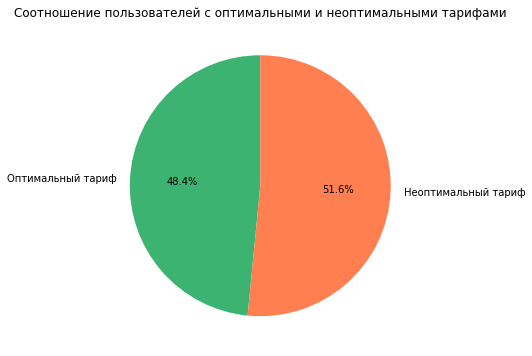

 Пользователей с оптимальными тарифами: 125
 Пользователей с неоптимальными тарифами: 133
 Всего активных пользователей: 258


In [45]:
# Анализ пользователей с оптимальными и неоптимальными тарифами
num_users_with_better_tariffs = users_with_better_tariffs['user_id'].nunique()

total_active_users = user_call_stats['user_id'].nunique()

num_users_with_optimal_tariffs = total_active_users - num_users_with_better_tariffs

labels = ["Оптимальный тариф", "Неоптимальный тариф"]
sizes = [num_users_with_optimal_tariffs, num_users_with_better_tariffs]
colors = ["mediumseagreen", "coral"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Соотношение пользователей с оптимальными и неоптимальными тарифами")
plt.show()

print(f" Пользователей с оптимальными тарифами: {num_users_with_optimal_tariffs}")
print(f" Пользователей с неоптимальными тарифами: {num_users_with_better_tariffs}")
print(f" Всего активных пользователей: {total_active_users}")

In [46]:
# Подсчитываем количество пользователей с неоптимальными тарифами по каждому тарифному плану
better_tariff_counts = users_with_better_tariffs.groupby('tariff_plan')['user_id'].nunique()

total_active_users_by_tariff = user_call_stats.groupby('tariff_plan')['user_id'].nunique()

tariff_mismatch_ratio = (better_tariff_counts / total_active_users_by_tariff) * 100

df_tariff_analysis = pd.DataFrame({
    "Всего активных пользователей": total_active_users_by_tariff,
    "Неоптимальных подключений": better_tariff_counts,
    "Доля неоптимальных подключений (%)": tariff_mismatch_ratio
}).fillna(0)  


df_tariff_analysis

,Всего активных пользователей,Неоптимальных подключений,Доля неоптимальных подключений (%)
tariff_plan,,,
A,30,22,73.333
B,96,68,70.833
C,132,43,32.576


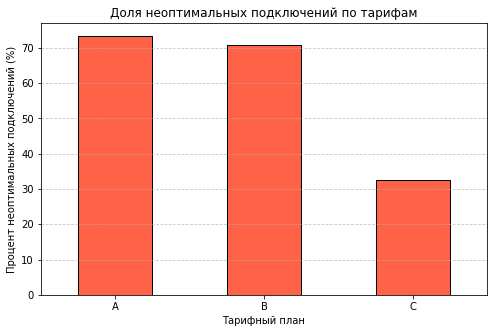

In [47]:
plt.figure(figsize=(8, 5))
df_tariff_analysis["Доля неоптимальных подключений (%)"].plot(kind='bar', color='tomato', edgecolor='black')

plt.title("Доля неоптимальных подключений по тарифам")
plt.xlabel("Тарифный план")
plt.ylabel("Процент неоптимальных подключений (%)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


 - Тариф A – самый проблемный, 73% пользователей могут сменить тариф и платить меньше.
 - Тариф В – 71% пользователей также имеют неоптимальный тариф.
 - Тариф С – 32.5% пользователей могли бы перейти на более выгодный вариант.

Распределение тарифов, если все пользователи перейдут на оптимальные:

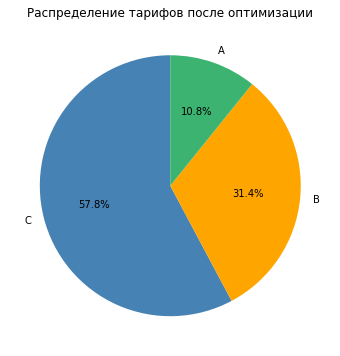

In [48]:
optimized_tariff_distribution = users_with_better_tariffs['better_tariff'].value_counts()

current_tariff_distribution = df_clients['tariff_plan'].value_counts()

new_tariff_distribution = current_tariff_distribution.copy()
for tariff, count in optimized_tariff_distribution.items():
    new_tariff_distribution[tariff] += count

for tariff, count in users_with_better_tariffs['tariff_plan'].value_counts().items():
    new_tariff_distribution[tariff] -= count

new_tariff_distribution = new_tariff_distribution.clip(lower=0)

plt.figure(figsize=(6, 6))
plt.pie(new_tariff_distribution, labels=new_tariff_distribution.index, autopct='%1.1f%%', colors=['steelblue', 'orange', 'mediumseagreen'], startangle=90)
plt.title("Распределение тарифов после оптимизации")
plt.show()


 - Доля тарифов А и B значительно снизилась, так как многие пользователи перешли на C.
 - Тариф С стал самым популярным, поскольку он оказался наиболее выгодным для многих клиентов.

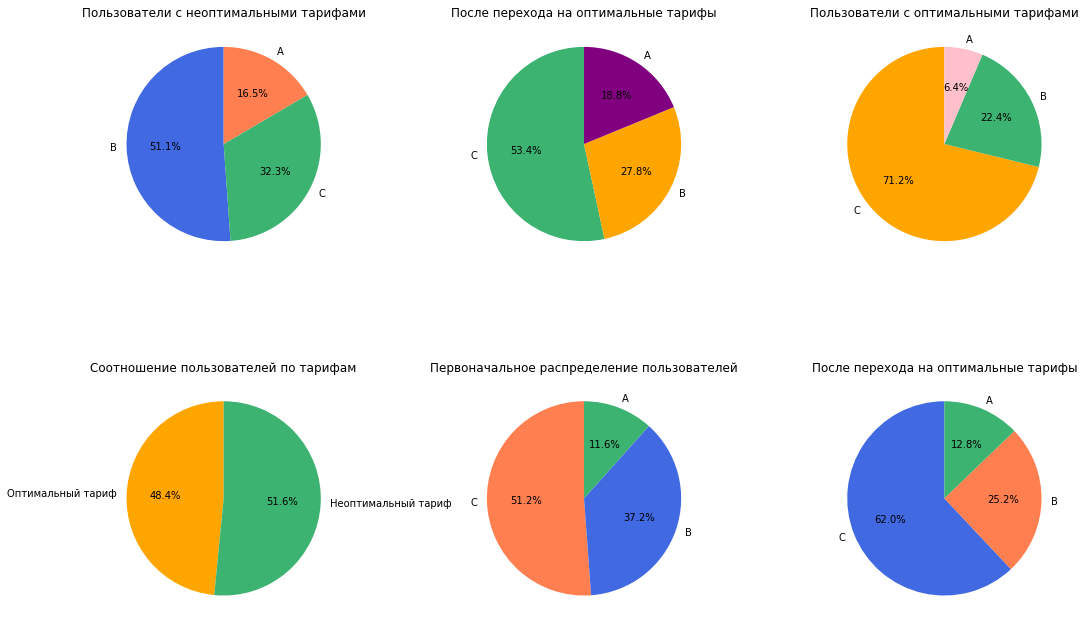

In [49]:
not_opt_current_tariffs = users_with_better_tariffs['tariff_plan'].value_counts()

not_opt_change_tariffs = users_with_better_tariffs['better_tariff'].value_counts()

opt_current_tariffs = user_call_stats[user_call_stats['better_tariff'].isna()]['tariff_plan'].value_counts()

all_users = {
    "Оптимальный тариф": opt_current_tariffs.sum(),
    "Неоптимальный тариф": not_opt_current_tariffs.sum()
}

# Первоначальное распределение пользователей по тарифам
initial_tariffs_dist = user_call_stats['tariff_plan'].value_counts()

# Распределение пользователей по тарифам после изменения тарифов на оптимальные
best_tariffs_dist = user_call_stats['better_tariff'].fillna(user_call_stats['tariff_plan']).value_counts()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# График 1: Распределение пользователей с неоптимальными тарифами
axes[0, 0].pie(not_opt_current_tariffs, labels=not_opt_current_tariffs.index, autopct='%1.1f%%', startangle=90, colors=['royalblue', 'mediumseagreen', 'coral'])
axes[0, 0].set_title("Пользователи с неоптимальными тарифами")

# График 2: Распределение после перехода на оптимальные тарифы
axes[0, 1].pie(not_opt_change_tariffs, labels=not_opt_change_tariffs.index, autopct='%1.1f%%', startangle=90, colors=['mediumseagreen','orange', 'purple'])
axes[0, 1].set_title("После перехода на оптимальные тарифы")

# График 3: Распределение пользователей с оптимальными тарифами
axes[0, 2].pie(opt_current_tariffs, labels=opt_current_tariffs.index, autopct='%1.1f%%', startangle=90, colors=['orange', 'mediumseagreen', 'pink'])
axes[0, 2].set_title("Пользователи с оптимальными тарифами")

# График 4: Соотношение пользователей с неоптимальными и оптимальными тарифами
axes[1, 0].pie(all_users.values(), labels=all_users.keys(), autopct='%1.1f%%', startangle=90, colors=['orange', 'mediumseagreen'])
axes[1, 0].set_title("Соотношение пользователей по тарифам")

# График 5: Первоначальное распределение пользователей по тарифам
axes[1, 1].pie(initial_tariffs_dist, labels=initial_tariffs_dist.index, autopct='%1.1f%%', startangle=90, colors=['coral', 'royalblue', 'mediumseagreen'])
axes[1, 1].set_title("Первоначальное распределение пользователей")

# График 6: Распределение пользователей после перехода на оптимальные тарифы
axes[1, 2].pie(best_tariffs_dist, labels=best_tariffs_dist.index, autopct='%1.1f%%', startangle=90, colors=['royalblue', 'coral', 'mediumseagreen'])
axes[1, 2].set_title("После перехода на оптимальные тарифы")

plt.tight_layout()
plt.show()


# Определим потери в выручке при переходе всех клиентов на оптимальные тарифы

In [50]:
current_revenue = user_call_stats['calculated_cost'].sum()

def calculate_new_cost(row):
    if pd.notna(row['better_tariff']):  
        new_tariff = tariff_details[row['better_tariff']]
        return new_tariff["monthly_fee"] + max(0, row['total_call_duration'] - new_tariff["included_minutes"]) * new_tariff["extra_minute_cost"]
    return row['calculated_cost']  

user_call_stats['optimized_cost'] = user_call_stats.apply(calculate_new_cost, axis=1)
optimized_revenue = user_call_stats['optimized_cost'].sum()

revenue_loss = current_revenue - optimized_revenue
revenue_loss_percentage = (revenue_loss / current_revenue) * 100

revenue_loss, revenue_loss_percentage


(463942.6499999999, 33.26278218562131)

Потери в среднемесячной выручке при переходе всех клиентов на оптимальные тарифы:
- Общие потери: 463942.70 ₽
- Процент снижения выручки: 33%

Выводы:
- Если все клиенты перейдут на более выгодные тарифы, выручка снизится на 33%.
- Текущая тарифная структура приносит больше дохода, так как пользователи переплачивают.

In [51]:
# Тааблица с клиентами, их текущими тарифами и рекомендованными новыми тарифами
df_final_recommendations = users_with_better_tariffs[['user_id', 'tariff_plan', 'better_tariff']].rename(
    columns={'tariff_plan': 'Старый тариф', 'better_tariff': 'Новый тариф'}
)

df_final_recommendations.head()

,user_id,Старый тариф,Новый тариф
0,166377,B,C
2,166392,C,A
3,166405,B,A
4,166406,B,C
7,166482,C,B


<div class="alert alert-success">
    
**Комментарий ревьюера - 2**

**#ок**

Хорошо. Но результаты могут сильно измениться при использовании полных данных.

При этом стоит посмотреть, как мы будем предлагать смену тарифов одну для каждого пользователя при рассмотрении нескольких месцев.

</div>

# Проверка статистических гипотез

Гипотеза 1: Клиенты с неоптимальными тарифами платят значительно больше, чем если бы использовали оптимальный тариф
- H₀ (нулевая гипотеза): Средняя стоимость связи у пользователей с неоптимальными тарифами не отличается от стоимости на оптимальном тарифе.
- H₁ (альтернативная гипотеза): Средняя стоимость связи у пользователей с неоптимальными тарифами значительно выше, чем на оптимальном тарифе.

In [52]:
# Используем тест Шапиро-Уилка для проверки нормальности распределения
shapiro_test_current = shapiro(user_call_stats['calculated_cost'])
shapiro_test_optimized = shapiro(user_call_stats['optimized_cost'])

print("Тест Шапиро-Уилка (проверка нормальности данных)")
print(f"Текущая стоимость связи: p-value = {shapiro_test_current.pvalue:.2e}")
print(f"Оптимальная стоимость связи: p-value = {shapiro_test_optimized.pvalue:.2e}")



Тест Шапиро-Уилка (проверка нормальности данных)
Текущая стоимость связи: p-value = 3.91e-32
Оптимальная стоимость связи: p-value = 3.34e-33


Обе выборки НЕ имеют нормального распределения (p-value < 0.05), поэтому t-тест использовать нельзя.

In [53]:
wilcoxon_test = wilcoxon(user_call_stats['calculated_cost'], user_call_stats['optimized_cost'])

# Выводим результат теста Уилкоксона
print("\n Результаты теста Уилкоксона (проверка различий в затратах)")
print(f"P-value = {wilcoxon_test.pvalue:.2e}")

if wilcoxon_test.pvalue < 0.05:
    print("**Гипотеза H₀ отвергается** – пользователи с неоптимальными тарифами платят значительно больше.")
    print(" Разница в стоимости связи статистически значима.")
else:
    print("**Гипотеза H₀ не отвергается** – различий в стоимости связи нет.")



 Результаты теста Уилкоксона (проверка различий в затратах)
P-value = 1.43e-23
**Гипотеза H₀ отвергается** – пользователи с неоптимальными тарифами платят значительно больше.
 Разница в стоимости связи статистически значима.


In [54]:
wilcoxon_test = wilcoxon(user_call_stats['calculated_cost'], user_call_stats['optimized_cost'])

# Вычисляем разности между стоимостями
differences = user_call_stats['calculated_cost'] - user_call_stats['optimized_cost']

p_value_one_sided = wilcoxon_test.pvalue / 2 #делим значимость на 2, т.к. проверяем одностороннюю гипотезу

# Выводим результат одностороннего теста Уилкоксона
print("\nРезультаты одностороннего теста Уилкоксона (проверка, что затраты ВЫШЕ на неоптимальном тарифе)")
print(f"P-value (односторонний) = {p_value_one_sided:.2e}")

if p_value_one_sided < 0.05:
    print("**Гипотеза H₀ отвергается** – пользователи с неоптимальными тарифами платят ЗНАЧИТЕЛЬНО БОЛЬШЕ.")
    print("Разница в стоимости связи статистически значима.")
else:
    print("**Гипотеза H₀ не отвергается** – пользователи с неоптимальными тарифами не платят больше.")


Результаты одностороннего теста Уилкоксона (проверка, что затраты ВЫШЕ на неоптимальном тарифе)
P-value (односторонний) = 7.14e-24
**Гипотеза H₀ отвергается** – пользователи с неоптимальными тарифами платят ЗНАЧИТЕЛЬНО БОЛЬШЕ.
Разница в стоимости связи статистически значима.


In [55]:
wilcoxon_test = wilcoxon(user_call_stats['calculated_cost'], user_call_stats['optimized_cost'])

from scipy.stats import wilcoxon

# Односторонний тест Вилкоксона (проверяем, что calculated_cost БОЛЬШЕ optimized_cost)
wilcoxon_test = wilcoxon(user_call_stats['calculated_cost'], user_call_stats['optimized_cost'], alternative='greater')

# Выводим результаты
print("\nРезультаты одностороннего теста Уилкоксона (проверка, что затраты ВЫШЕ на неоптимальном тарифе)")
print(f"P-value (односторонний) = {wilcoxon_test.pvalue:.2e}")

if wilcoxon_test.pvalue < 0.05:
    print("**Гипотеза H₀ отвергается** – пользователи с неоптимальными тарифами платят ЗНАЧИТЕЛЬНО БОЛЬШЕ.")
    print("Разница в стоимости связи статистически значима.")
else:
    print("**Гипотеза H₀ не отвергается** – пользователи с неоптимальными тарифами не платят больше.")


Результаты одностороннего теста Уилкоксона (проверка, что затраты ВЫШЕ на неоптимальном тарифе)
P-value (односторонний) = 7.14e-24
**Гипотеза H₀ отвергается** – пользователи с неоптимальными тарифами платят ЗНАЧИТЕЛЬНО БОЛЬШЕ.
Разница в стоимости связи статистически значима.


Гипотеза: Клиенты, которые часто превышают лимиты минут, тратят на связь больше, чем клиенты, остающиеся в пределах лимита.

 - H₀ (нулевая гипотеза): Средняя стоимость связи у клиентов, превышающих лимиты минут, не отличается от средней стоимости у остальных пользователей.

 - H₁ (альтернативная гипотеза): Клиенты, выходящие за лимиты минут, тратят на связь значительно больше, чем те, кто остается в пределах тарифного пакета.

In [56]:
user_call_stats_filtered = df_calls_filtered.groupby(['user_id', 'tariff_plan']).agg(
    total_call_duration=('total_call_duration', 'sum'),
    total_calls=('calls_count', 'sum'),
    unique_operators=('operator_id', 'nunique'),
    external_call_duration=('total_call_duration', lambda x: x[df_calls_filtered['internal'] == False].sum())
).reset_index()

# Определение превышения лимита минут с учетом тарифа
user_call_stats_filtered['limit_exceeded'] = user_call_stats_filtered.apply(
    lambda row: row['total_call_duration'] > tariff_details[row['tariff_plan']]["included_minutes"], axis=1
)

# Функция расчета затрат с учетом всех параметров тарифа
def calculate_full_cost(row):
    tariff = tariff_details[row['tariff_plan']]
    base_cost = tariff["monthly_fee"]
    extra_minutes_cost = max(0, row['total_call_duration'] - tariff["included_minutes"]) * tariff["extra_minute_cost"]
    operator_fee = row['unique_operators'] * tariff["operator_fee"]
    external_calls_cost = row['external_call_duration'] * tariff["external_call_cost"]
    
    return base_cost + extra_minutes_cost + operator_fee + external_calls_cost

user_call_stats_filtered['calculated_cost'] = user_call_stats_filtered.apply(calculate_full_cost, axis=1)

user_costs_filtered = user_call_stats_filtered.groupby(['user_id', 'limit_exceeded'])['calculated_cost'].mean().reset_index()

group_over_limit_filtered = user_costs_filtered[user_costs_filtered['limit_exceeded'] == True]['calculated_cost']
group_within_limit_filtered = user_costs_filtered[user_costs_filtered['limit_exceeded'] == False]['calculated_cost']

# Проверка нормальности распределения (тест Шапиро-Уилка)
shapiro_over_filtered = st.shapiro(group_over_limit_filtered)
shapiro_within_filtered = st.shapiro(group_within_limit_filtered)

shapiro_over_filtered.pvalue, shapiro_within_filtered.pvalue


(9.328925353154015e-31, 6.451794831718871e-08)


Используем критерий Манна-Уитни, т.к. выборки независимые, а распределение данных не нормально.

In [57]:
# Так как данные не нормальны, используем критерий Манна-Уитни

mann_whitney_test = st.mannwhitneyu(group_over_limit_filtered, group_within_limit_filtered, alternative='greater')

print("Результаты теста Манна-Уитни (проверка различий в затратах)")
print(f"Статистика теста: {mann_whitney_test.statistic:.2f}, p-value = {mann_whitney_test.pvalue:.2e}")

alpha = 0.05  # Уровень статистической значимости
if mann_whitney_test.pvalue < alpha:
    print("Гипотеза H₀ отвергается – клиенты, превышающие лимиты минут, действительно тратят больше.")
else:
    print("Гипотеза H₀ не отвергается – различий в стоимости связи нет.")


Результаты теста Манна-Уитни (проверка различий в затратах)
Статистика теста: 7598.00, p-value = 2.34e-06
Гипотеза H₀ отвергается – клиенты, превышающие лимиты минут, действительно тратят больше.


- Можно создать доп. опции и гибкие пакеты, чтобы клиенты не меняли тариф, но могли докупать минуты.
- Можно таргетировать этих клиентов с предложением пакетов дополнительных минут вместо смены тарифа.

# Общий вывод по проекту

## Предобработка данных и выявление аномалий  
- Привели данные к нужному формату, удалили 4900 дубликатов и обработали 7456 пропусков в `operator_id`, большинство из которых связано с пропущенными вызовами.  
- Выяснили, что в базе 732 клиента, но только 307 реально совершают звонки.  
- Обнаружили аномальных клиентов, у которых операторы говорили более 24 часов в сутки.  
- Исключили этих оператороа из анализа, так как их данные могут быть ошибочными или связаны с особенностями работы (например, круглосуточный режим или технические проблемы).  

## Общий анализ звонков и тарифов  
- Исходящих звонков больше, чем входящих, что подтверждает активное использование связи клиентами.  
- Количество звонков падает в выходные дни, возможно, из-за снижения деловой активности.  
- Тариф A – самый популярный, а тариф B чаще всего неоптимален.  
- Средняя длительность звонков различается по тарифам:  
  - Тариф A – средняя длительность звонка 428 минуты.  
  - Тарифы B и C – звонки короче (≈163 и 137 минут соответственно).  

##  Ошибки в данных и аномальные звонки  
- Обнаружили аномально длинные звонки.
- Это говорит о возможных ошибках в учете данных, когда звонки не были разделены на отдельные вызовы.  

## Анализ неоптимальных тарифов  
- Более половины пользователей могли бы платить меньше, выбрав другой тариф.  
- Если все клиенты перейдут на выгодные тарифы, выручка компании снизится на 33% (~463942₽ в месяц).  
- На тарифе А 74% клиентов переплачивают, что делает его самым невыгодным для пользователей.  
- Внешние звонки преобладают во всех тарифах, внутренние составляют менее 3%.  

## Проверка статистических гипотез  
- **Гипотеза 1: Клиенты с неоптимальными тарифами платят больше**  
  - Тест Вилкоксона показал, что разница статистически значима.  
  - Пользователи с неоптимальными тарифами действительно переплачивают.  

- **Гипотеза 2: Клиенты, превышающие лимиты минут, тратят больше**  
  - Тест Манна-Уитни подтвердил, что такие клиенты действительно тратят больше.  
  - Это говорит о том, что такие пользователи могут быть целевой аудиторией для дополнительных пакетов минут.  

## Рекомендации  
**Как уменьшить потери выручки при переходе на выгодные тарифы?**
- Ввести гибкие тарифные планы с возможностью докупки минут.  
- Создать персонализированные предложения клиентам, чтобы удерживать их на текущих тарифах.  
- Монетизировать дополнительные услуги (аналитика звонков, приоритетное соединение, корпоративные пакеты).  


Проект показал, что значительная часть клиентов переплачивает, а компания может потерять часть выручки при переходе на оптимальные тарифы. Однако, с правильной стратегией можно сохранить доход и улучшить клиентский опыт.  
